In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import os
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from hcrot import layers, optim
from hcrot.dataset import *
from hcrot.utils import *

In [3]:
lr_rate= 1e-2
epochs = 10

In [ ]:
df = pd.read_csv("./datasets/mnist_test.csv")
label = df['7'].to_numpy()
df = df.drop('7', axis=1)
dat = (df / 255.).to_numpy().astype(np.float32)

dataset_len = len(dat)
dat = dat.reshape(dataset_len, 1, 28, 28)

train_image, test_image = dat[:5000], dat[8001:9001]
train_label, test_label = label[:5000], label[8001:9001]

train_image.shape, test_image.shape

((5000, 1, 28, 28), (1000, 1, 28, 28))

Text(0.5, 1.0, 'label: 9')

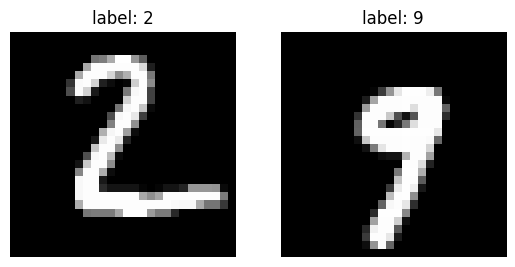

In [5]:
import matplotlib.pyplot as plt
_, axs = plt.subplots(1,2)
axs[0].imshow(train_image[0].reshape(28,28,1), cmap='gray') # (C,H,W) -> (H,W,C)
axs[1].imshow(test_image[0].reshape(28,28,1), cmap='gray')
axs[0].axis('off')
axs[1].axis('off')
axs[0].set_title(f'label: {train_label[0]}')
axs[1].set_title(f'label: {test_label[0]}')

In [6]:
dataloader = Dataloader(train_image, train_label, batch_size=50, shuffle=True)
testloader = Dataloader(test_image, test_label, batch_size=1, shuffle=False)

In [7]:
class CNN(layers.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.layer1 = layers.Sequential(
            layers.Conv2d(1,3,3),
            layers.ReLU(),
            layers.MaxPool2d(2,2)
        )
        self.layer2 = layers.Sequential(
            layers.Conv2d(3,5,3),
            layers.ReLU(),
            layers.MaxPool2d(2,2)
        )
        self.flatten = layers.Flatten()
        self.dropout = layers.Dropout(p=0.5)
        self.fc = layers.Linear(125, num_classes)

    def forward(self, x):
        for module in self.layer1:
            x = module(x)
        for module in self.layer2:
            x = module(x)
        return self.fc(self.flatten(x))

In [8]:
model = CNN()
criterion = layers.CrossEntropyLoss()
optimizer = optim.Adam(model, lr_rate=lr_rate)

In [9]:
for epoch in range(epochs):
    total_loss, correct = 0, 0

    model.train()
    for images, labels in dataloader:
        logits = model(images)
        loss = criterion(logits, labels)

        total_loss += loss.item()
        dz = criterion.backward()
        optimizer.update(dz)

    model.eval()
    for images, labels in testloader:
        logits = model(images)
        predictions = np.argmax(logits, axis=1)
        correct += (predictions == labels).item()

    print(f'Epoch [{epoch+1} / {epochs}] | Loss: {total_loss / len(dataloader):.3f} | Acc: {correct / len(testloader):.3f}')

Epoch [1 / 10] | Loss: 1.032 | Acc: 0.882
Epoch [2 / 10] | Loss: 0.351 | Acc: 0.924
Epoch [3 / 10] | Loss: 0.258 | Acc: 0.936
Epoch [4 / 10] | Loss: 0.220 | Acc: 0.960
Epoch [5 / 10] | Loss: 0.189 | Acc: 0.963
Epoch [6 / 10] | Loss: 0.175 | Acc: 0.967
Epoch [7 / 10] | Loss: 0.164 | Acc: 0.962
Epoch [8 / 10] | Loss: 0.155 | Acc: 0.964
Epoch [9 / 10] | Loss: 0.145 | Acc: 0.959
Epoch [10 / 10] | Loss: 0.135 | Acc: 0.955
